In [2]:
# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import copy
from IPython.display import display
import json
from pathlib import Path
import sys

(b) We now consider that the consumer described in Question 1.(a) does not have a strict
daily energy consumption requirement. Instead, it is interested, in minimizing the
discomfort uncured from shifting its flexible load at each hour compared to a reference
hourly load profile, in addition to minimizing its energy procurement cost through the
day. And we analyze the impact on its flexibility and profits.

iv. (1 point) Implement this optimization problem in a programming language of your
choice. Provide a well-documented working code.

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[rosetta2] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120 rows, 120 columns and 240 nonzeros
Model fingerprint: 0xe96c72ec
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 3e+00]
  RHS range        [1e-01, 3e+00]
Presolve removed 75 rows and 62 columns
Presolve time: 0.00s
Presolved: 45 rows, 58 columns, 103 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0360000e+31   2.600000e+31   1.036000e+01      0s
      39    2.4023250e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.402325000e+01

Hourly schedule (hours 0..23):
 t | price | pv_avail | r (ref) | x (load) | d (dev) | u (pv used) | import I | export E
 0 |  1

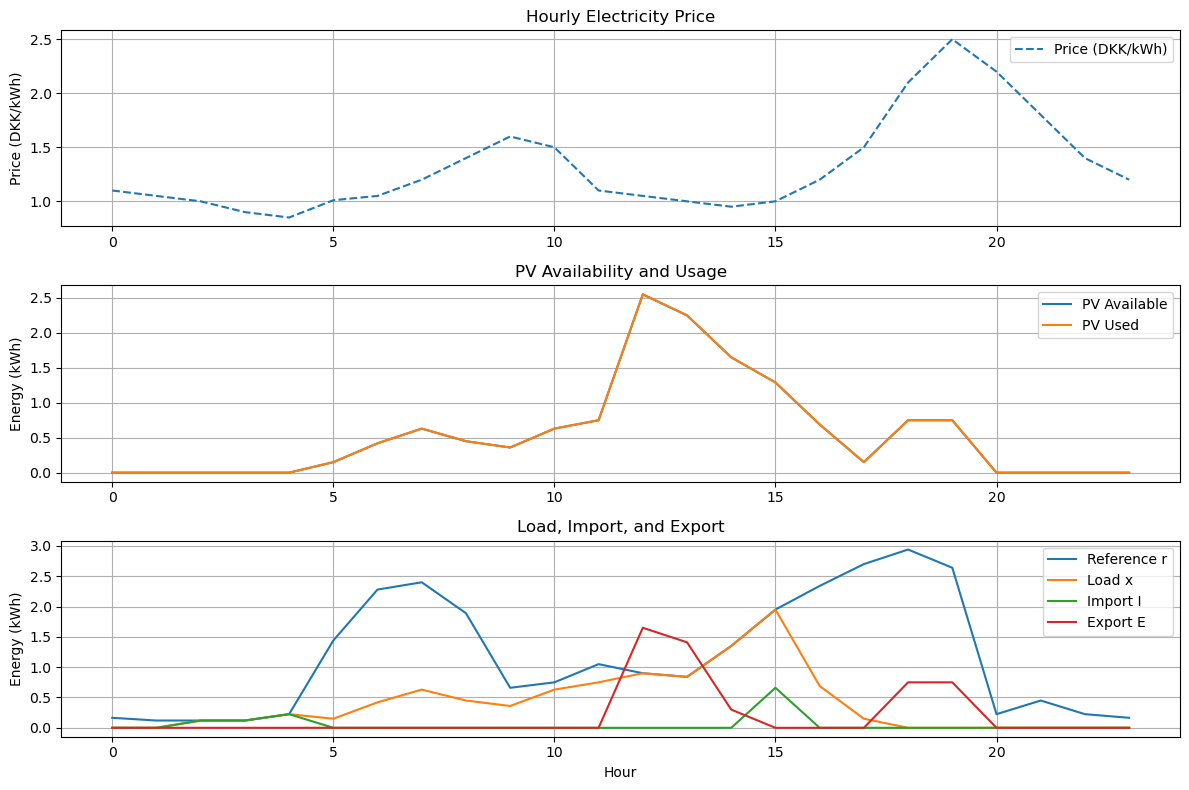

In [11]:
# Utility to load JSON
def load_json(path: Path):
    if path.exists():
        return json.loads(path.read_text())
    return None

# Paths
base_folder = Path("data/question_1b/")
appliance_path = base_folder / "appliance_params.json"
bus_path = base_folder / "bus_params.json"
consumer_path = base_folder / "consumer_params.json"
der_prod_path = base_folder / "DER_production.json"
usage_pref_path = base_folder / "usage_preferences.json"

appliance_params = load_json(appliance_path)
bus_params = load_json(bus_path)
consumer_params = load_json(consumer_path)
DER_production = load_json(der_prod_path)
usage_pref = load_json(usage_pref_path)

# Single consumer / bus assumption for this assignment
consumer = consumer_params[0]
bus = bus_params[0]

# Extract specs
pv_spec = appliance_params["DER"][0]
pv_max_kW = float(pv_spec["max_power_kW"])

load_spec = appliance_params["load"][0]
load_max_kWh = float(load_spec["max_load_kWh_per_hour"])

prices = bus["energy_price_DKK_per_kWh"]
if len(prices) != 24:
    raise SystemExit("Expected 24 hourly prices; got %d" % len(prices))

import_tariff = float(bus["import_tariff_DKK/kWh"])
export_tariff = float(bus["export_tariff_DKK/kWh"])
max_import = float(bus["max_import_kW"])
max_export = float(bus["max_export_kW"])

der_profile = DER_production[0]["hourly_profile_ratio"]
if len(der_profile) != 24:
    raise SystemExit("Expected 24 hourly DER profile entries")

pv_avail = [pv_max_kW * float(r) for r in der_profile]

# Usage preferences: reference hourly profile ratios
load_prefs = usage_pref[0].get("load_preferences", [])
if not load_prefs:
    raise SystemExit("No load_preferences found in usage_preference.json")
lp0 = load_prefs[0]
hourly_profile_ratio = lp0.get("hourly_profile_ratio", None)
if hourly_profile_ratio is None or len(hourly_profile_ratio) != 24:
    raise SystemExit("Expected a 24-entry hourly_profile_ratio for the load in usage_preference.json")

# Reference profile r_t = ratio * max_load (kWh per hour)
r = [float(ratio) * load_max_kWh for ratio in hourly_profile_ratio]

# Discomfort penalty gamma (DKK per kWh). Use value from JSON if present, else default.
default_gamma = 1.5
gamma = float(lp0.get("discomfort_penalty_DKK_per_kWh", default_gamma))

# Daily minimum energy (may be null)
min_equivalent_hours = lp0.get("min_total_energy_per_day_hour_equivalent", None)
E_min = None
if min_equivalent_hours is not None:
    E_min = float(min_equivalent_hours) * load_max_kWh

T = list(range(24))

# Build model
m = gp.Model("consumer_flex_lp_with_discomfort")
m.setParam('OutputFlag', 1)

# Variables
x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
u = m.addVars(T, lb=0.0, name="u")          # cap by PV availability constraints
I = m.addVars(T, lb=0.0, name="I")
E = m.addVars(T, lb=0.0, name="E")
d = m.addVars(T, lb=0.0, name="d")         # absolute deviation variables

# PV availability constraints
for t in T:
    m.addConstr(u[t] <= pv_avail[t], name=f"pv_cap_{t}")

# Energy balance
for t in T:
    m.addConstr(I[t] - E[t] + u[t] == x[t], name=f"balance_{t}")

# Load upper bound (already in var definition, but keep for clarity)
for t in T:
    m.addConstr(x[t] <= load_max_kWh, name=f"load_cap_{t}")

# Deviation linearization constraints: d_t >= x_t - r_t and d_t >= r_t - x_t
for t in T:
    m.addConstr(d[t] >= x[t] - r[t], name=f"dev_pos_{t}")
    m.addConstr(d[t] >= r[t] - x[t], name=f"dev_neg_{t}")
    # d[t] >= 0 is enforced by variable lb

# Objective: energy procurement cost + gamma * sum(d)
energy_cost = gp.quicksum((prices[t] + import_tariff) * I[t] - (prices[t] - export_tariff) * E[t] for t in T)
discomfort_cost = gamma * gp.quicksum(d[t] for t in T)
m.setObjective(energy_cost + discomfort_cost, GRB.MINIMIZE)

# Optimize
m.optimize()

if m.status != GRB.OPTIMAL:
    print("Optimization status:", m.status)

# Results
x_sol = [x[t].X for t in T]
u_sol = [u[t].X for t in T]
I_sol = [I[t].X for t in T]
E_sol = [E[t].X for t in T]
d_sol = [d[t].X for t in T]

total_import = sum(I_sol)
total_export = sum(E_sol)
total_load = sum(x_sol)
total_pv_used = sum(u_sol)
total_deviation = sum(d_sol)
objective_value = m.ObjVal

print("\nHourly schedule (hours 0..23):")
print(" t | price | pv_avail | r (ref) | x (load) | d (dev) | u (pv used) | import I | export E")
for t in T:
    print(f"{t:2d} | {prices[t]:5.2f} | {pv_avail[t]:7.3f} | {r[t]:7.3f} | {x_sol[t]:7.3f} | {d_sol[t]:7.3f} | {u_sol[t]:10.3f} | {I_sol[t]:8.3f} | {E_sol[t]:8.3f}")

print("\nTotals:")
print(f" Total load (sum x):        {total_load:.3f} kWh")
print(f" Total PV used (sum u):     {total_pv_used:.3f} kWh")
print(f" Total import (sum I):      {total_import:.3f} kWh")
print(f" Total export (sum E):      {total_export:.3f} kWh")
print(f" Total absolute deviation:  {total_deviation:.3f} kWh")
print(f" Objective (total cost):    {objective_value:.3f} DKK")


# Print binding constraints
print("\nBinding constraints (tight):")
for constr in m.getConstrs():
    if abs(constr.Slack) < 1e-6:
        try:
            print(f" {constr.ConstrName} is binding. Dual: {constr.Pi:.6f}")
        except Exception:
            print(f" {constr.ConstrName} is binding.")

# Plot schedule
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(T, prices, label="Price (DKK/kWh)", linestyle='--')
plt.ylabel("Price (DKK/kWh)")
plt.title("Hourly Electricity Price")
plt.grid()
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(T, pv_avail, label="PV Available")
plt.plot(T, u_sol, label="PV Used")
plt.ylabel("Energy (kWh)")
plt.title("PV Availability and Usage")
plt.grid()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(T, r, label="Reference r")
plt.plot(T, x_sol, label="Load x")
plt.plot(T, I_sol, label="Import I")
plt.plot(T, E_sol, label="Export E")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.title("Load, Import, and Export")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


v. (4 points) Construct relevant scenarios of consumer flexibility preferences based on
the data provided1, solve this optimization problem over these scenarios, analyze
its optimal solutions (primal and dual) and answer the following question: How do
the flexibility preferences of consumers impact their flexibility and profits? Present
your insights in a compact manner using adequate visual aids. Do these solutions
align with your analysis from Question 1.(b).iii.?


Gamma sweep results:
Gamma | Cost (DKK) | Total deviation (kWh) | Total load (kWh) | Import (kWh) | Export (kWh)
---------------------------------------------------------------
 0.00 |         -11.225 |             27.945 |           0.000 |       0.000 |      13.470
 0.50 |           2.748 |             27.945 |           0.000 |       0.000 |      13.470
 1.00 |          14.251 |             20.925 |           7.020 |       0.000 |       6.450
 1.50 |          24.023 |             18.210 |           9.735 |       1.125 |       4.860
 2.00 |          29.952 |              5.805 |          22.140 |      12.780 |       4.110
 2.50 |          32.345 |              4.305 |          23.640 |      13.530 |       3.360
 3.00 |          33.554 |              0.000 |          27.945 |      17.835 |       3.360


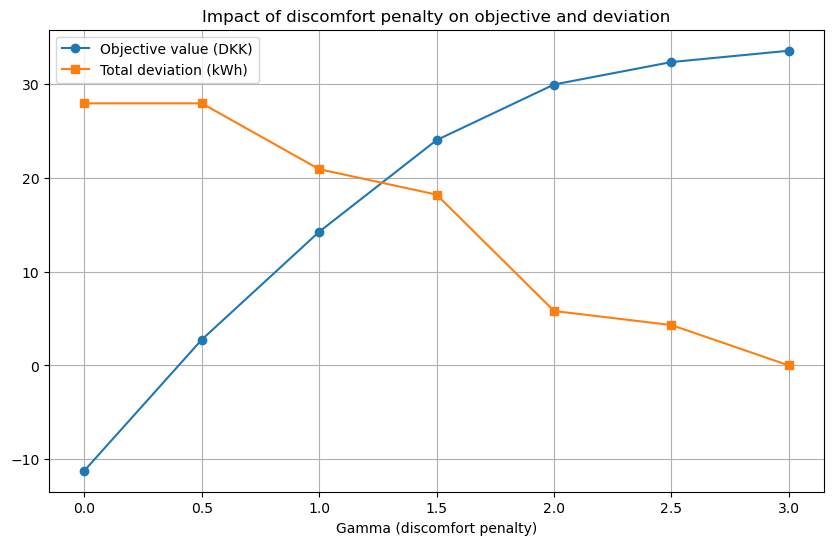

In [12]:
# ---------- Function to run optimization for a given gamma ----------
def run_optimization(gamma_value):
    m = gp.Model(f"consumer_flex_gamma_{gamma_value}")
    m.setParam('OutputFlag', 0)

    # Variables
    x = m.addVars(T, lb=0.0, ub=load_max_kWh, name="x")
    u = m.addVars(T, lb=0.0, name="u")
    I = m.addVars(T, lb=0.0, name="I")
    E = m.addVars(T, lb=0.0, name="E")
    d = m.addVars(T, lb=0.0, name="d")

    # Constraints
    for t in T:
        m.addConstr(u[t] <= pv_avail[t])
        m.addConstr(I[t] - E[t] + u[t] == x[t])
        m.addConstr(d[t] >= x[t] - r[t])
        m.addConstr(d[t] >= r[t] - x[t])

    # Objective
    energy_cost = gp.quicksum((prices[t] + import_tariff) * I[t] - (prices[t] - export_tariff) * E[t] for t in T)
    discomfort_cost = gamma_value * gp.quicksum(d[t] for t in T)
    m.setObjective(energy_cost + discomfort_cost, GRB.MINIMIZE)

    m.optimize()

    # Extract results
    results = {
        "gamma": gamma_value,
        "objective": m.ObjVal,
        "total_import": sum(I[t].X for t in T),
        "total_export": sum(E[t].X for t in T),
        "total_load": sum(x[t].X for t in T),
        "total_deviation": sum(d[t].X for t in T)
    }
    return results

# ---------- Run scenarios ----------
gammas = np.arange(0, 3.5, 0.5)
results = [run_optimization(g) for g in gammas]

# ---------- Print summary ----------
print("\nGamma sweep results:")
print("Gamma | Cost (DKK) | Total deviation (kWh) | Total load (kWh) | Import (kWh) | Export (kWh)")
print("---------------------------------------------------------------")
for res in results:
    print(f"{res['gamma']:5.2f} | {res['objective']:15.3f} | {res['total_deviation']:18.3f} | {res['total_load']:15.3f} | {res['total_import']:11.3f} | {res['total_export']:11.3f}")

# ---------- Plot summary ----------
plt.figure(figsize=(10,6))
plt.plot(gammas, [r["objective"] for r in results], marker="o", label="Objective value (DKK)")
plt.plot(gammas, [r["total_deviation"] for r in results], marker="s", label="Total deviation (kWh)")
plt.xlabel("Gamma (discomfort penalty)")
plt.grid(True)
plt.legend()
plt.title("Impact of discomfort penalty on objective and deviation")
plt.show()
